### **Mini-project n° 2 – Conditional VAEs**
Groupe 5: Vilde , Laura, Chung et Min-Thi

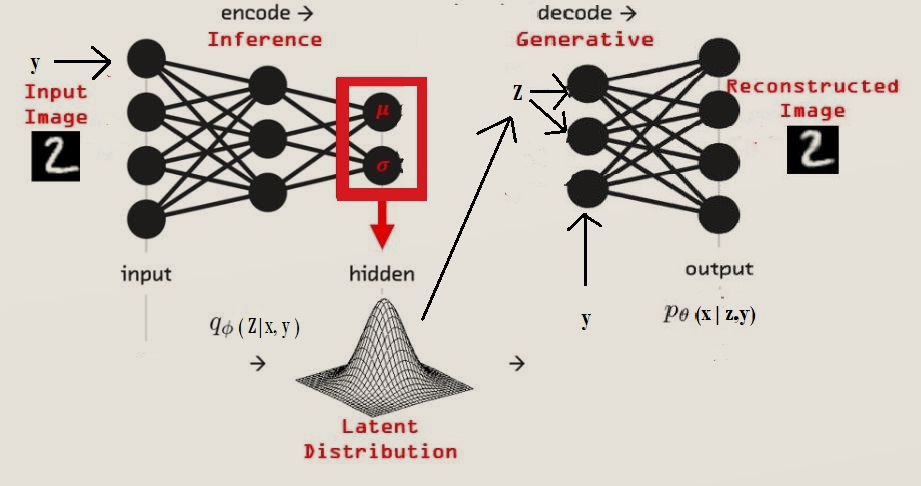



---



# Introduction and theory

The Conditional Variational Autoencoder (CVAE) was introduced in 2015 by Kingma, D.P., & Welling, M. in the paper "Learning Structured Output Representation" (Sohn, Yan, & Lee, 2015). As the name implies, this variational autoencoder adds conditional information to the latent space, allowing the model to generate outputs based on specific conditions, such as labels or other input features.

By conditioning the latent variable on additional information, the CVAE can model complex data distributions while also generating samples that are conditioned on specific labels.

During the making of the CVAE model in this project notebook we will look furter into how the conditional information works using the FashionMNIST dataset (Zalando Research, n.d.).


### The CVAE loss function

The Conditional Variational Autoencoder (CVAE) loss function is defined as:

$$
\mathcal{L}(x, y; \theta, \phi) = \mathbb{E}_{q_{\phi}(z|x,y)}[\log p_{\theta}(y|x,z)] - \text{KL}(q_{\phi}(z|x,y) \parallel p_{\theta}(z|x))
$$

We will in this notebook use the β-weighted KL divergence to further explore the unfluence of the KL divergence

CVAE loss function ith β-weighted KL divergence:
$$
L(x, y; \theta, \phi) = \mathbb{E}_{q_{\phi}(z|x,y)} \left[ \log p_{\theta}(y|x,z) \right] - \beta \cdot \text{KL} \left( q_{\phi}(z|x,y) \parallel p_{\theta}(z|x) \right)
$$


Where:
- $x$ is the input data,
- $y$ is the conditional target data,
- $q_{\phi}(z|x,y)$ is the encoder (approximate posterior),
- $p_{\theta}(y|x,z)$ is the decoder (likelihood),
- $p_{\theta}(z|x)$ is the prior distribution,
- β controls the weight of the KL divergence term in the loss function.
- and $\text{KL}$ is the Kullback-Leibler divergence.


The Loss function contains two key components: the reconstruction loss and the Kullback-Leibler (KL) divergence.

* The reconstruction loss ensures the accuracy of the outpt "y" form the input "x" and the latent space "z". It ensures that the loss function is sensitive enough.

* The KL Divergence on the other hand ensures that the loss function is insensitive enough. It regularizes the latent space, ensuring that the posterior distribution (the distribution of latent variables learned from the data) is close to the prior distribution (the simple, predefined distribution), preventing overfitting and encouraging generalization. We want the posterior to not stray too far from the prior.

In addition the beta parameter controls the trade-off between reconstruction accuracy and the regularization of the latent space. A higher β places more importance on regularization, while a lower β prioritizes reconstruction.

## CVAE vs VAE


### Loss function

The loss function used in a traditional variational eutoencoder (VAE) is :
$$
L(x; \theta, \phi) = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - \text{KL}(q_\phi(z|x) \parallel p_\theta(z))
$$

As the name says, and as we have seen the CVAE adds a conditioning on the input.
* In VAE, the loss function is based solely on the input data x, where the encoder $qϕ(z∣x)$ and the decoder $pθ(x∣z)$ are both conditioned on x.
* In CVAE, both the encoder and decoder are conditioned on both the input x **and the additional condition y**. The encoder $qϕ(z∣x,y)$ and the decoder $pθ(x∣z,y)$ take y into account, making the model capable of conditional generation.

### Conditional generation

As mentioned above using a CVAE alows conditional generation. Lets look at the difference this makes whan comparing to a traditional VAE.

* Without conditioning (VAE): The model learns to generate random images based on the overall distribution of all the clothing types, without any control over which specific clothing type is generated.

* With conditioning (CVAE): The model takes a condition (e.g., a label for the clothing type) as an additional input. Now, you can specify the type of clothing you want the model to generate (e.g., "generate a pair of shoes"). The model will then generate data (images) based on the condition you provide.

# Implementing the Conditional Variational Autoencoder (CVAE)

The following work is based on the practical work done during the HDDL course (in particular the vae notebook) but adding the conditional dimension and additional explorations.

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Loading the train and test dataset

In [ ]:
from torchvision import datasets, transforms
batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.6MB/s]


Extracting ../../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 213kB/s]


Extracting ../../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]


Extracting ../../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 23.6MB/s]

Extracting ../../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/FashionMNIST/raw



Lets now look at the sizes of the datasets and the size of the images.

In [ ]:
train_data_size = len(train_dataset)
test_data_size = len(test_dataset)

print(f"Training set size: {train_data_size}")
print(f"Test set size: {test_data_size}")
print(f"Image shape: {train_dataset[0][0].shape}")

Training set size: 60000
Test set size: 10000
Image shape: torch.Size([1, 28, 28])


The names of the classes is the FashionMnist data set are the following:

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Lets now look at the distibution of data in each class of the dataset.


Class distribution in the training dataset:

Class Distribution (Training Data)
T-shirt/top: 6000 images
Trouser: 6000 images
Pullover: 6000 images
Dress: 6000 images
Coat: 6000 images
Sandal: 6000 images
Shirt: 6000 images
Sneaker: 6000 images
Bag: 6000 images
Ankle boot: 6000 images


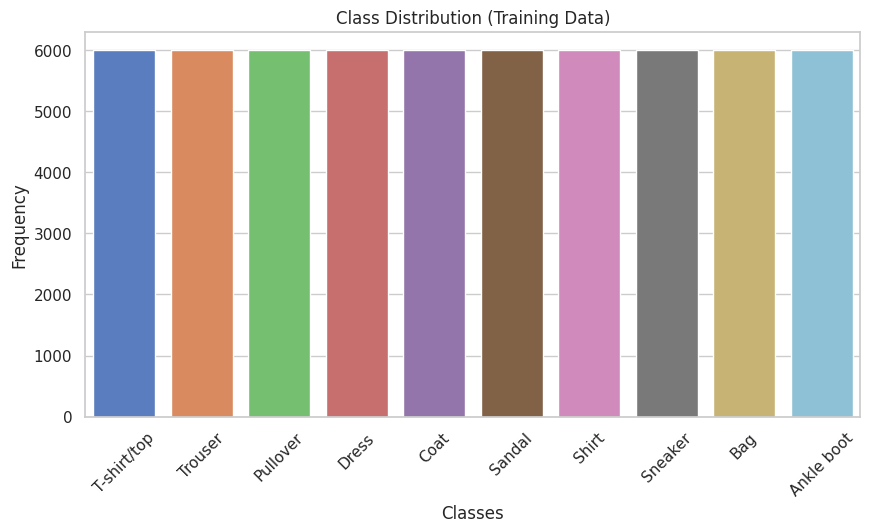


Class distribution in the test dataset:

Class Distribution (Test Data)
T-shirt/top: 1000 images
Trouser: 1000 images
Pullover: 1000 images
Dress: 1000 images
Coat: 1000 images
Sandal: 1000 images
Shirt: 1000 images
Sneaker: 1000 images
Bag: 1000 images
Ankle boot: 1000 images


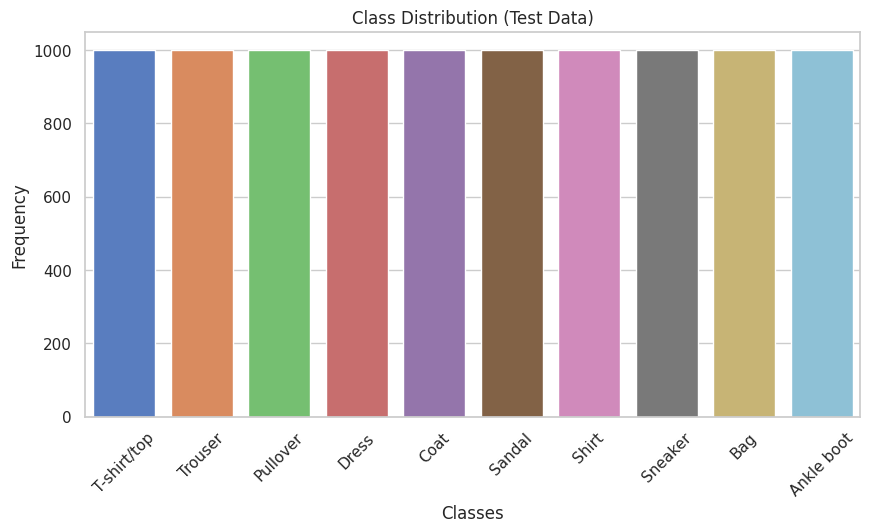

In [ ]:
import seaborn as sns
def plot_class_distribution(dataset, class_names, title):
    labels = [label for _, label in dataset]
    class_counts = {class_name: labels.count(idx) for idx, class_name in enumerate(class_names)}

    print(f"\n{title}")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")

    # Plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 5))
    sns.countplot(x=labels, hue=labels, palette="muted", order=np.arange(len(class_names)), dodge=False, legend=False)
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Frequency")
    plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
    plt.show()

print("\nClass distribution in the training dataset:")
plot_class_distribution(train_dataset, class_names, "Class Distribution (Training Data)")

print("\nClass distribution in the test dataset:")
plot_class_distribution(test_dataset, class_names, "Class Distribution (Test Data)")

We can see that we are working with a well-rounded dataset (equal amount of data in each class), and we do not need to modify our dataset in any way. Let's now visualize the dataset.

## Visualizing a Batch of Fashion-MNIST Images

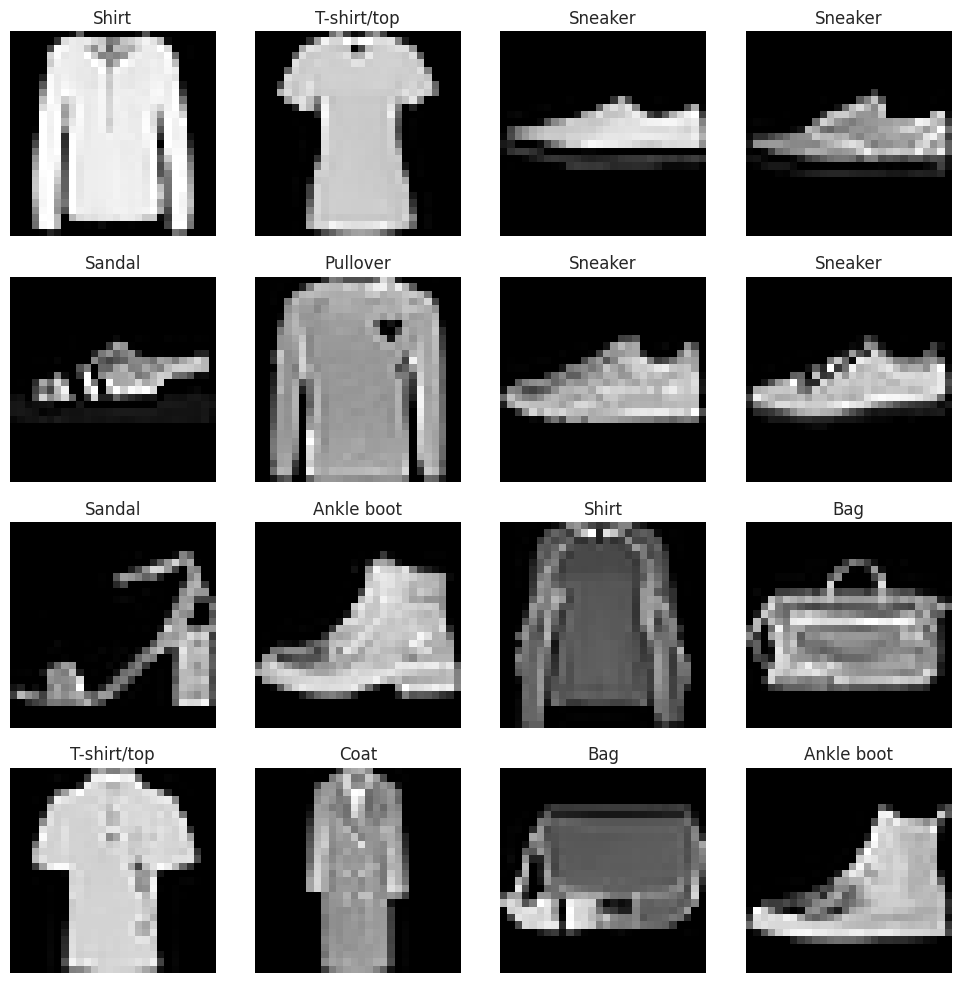

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Get one batch of images and labels
images, labels = next(iter(train_loader))

# Plot the batch of images
plt.figure(figsize=(10, 10))
for i in range(batch_size):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

We observe that the images are relatively low in quality, but in this project, our CVAE model will be able to learn structured latent representations and generate new images conditioned on labels.

## The CVAE model

### The encoder:

* Consist of three convolutional layers from which it learns features. Each convolutional layer reduces the dimensions of the input image while increasing the depth of the feature maps.

* After each convolutional layer we do a batch normalization. The batch normalization normalizes the inputs to each layer, ensuring that they have a consistent mean and variance across batches.

* The ReLU activation function is used throughout the encoder and decoder. This function helps avoid the vanishing gradient problem and facilitates easier computations by setting negative values to zero, there by deactivating those neurons.

### Fully Connected Layers for Latent Space
 * After the convolutional layers, the model flattens the feature map into a vector of size 128 * 4 * 4 (i.e., a flattened 128-channel 4x4 feature map). This vector is concatenated with the condition vector (the class label, one-hot encoded) to create the input for the fully connected layers. This conditioning allows the model to generate class-specific samples during decoding.

 * The network outputs two values: the mean (fc_mu) and the log variance (fc_logvar). The encoder takes in the input data and its associated condition (label) to generate the values. These mean and log variance values define a Gaussian distribution, from which we sample the latent vector z during training, using the parameterization trick.



### The decoder:

Like the encoder, the decoder also implement batch normalization, and uses the ReLU activation function. However, there are some important differences:

* The decoder uses ConvTranspose2d (deconvolutional layers) instead of Conv2d (convolution layers). The deconvolution layers increase the spatial dimensions instead of reducing them, which allows us to rebuild a reconstructed image from the latent representation.

* For the last layer of the decoder, a Sigmoid activation function is used to produce pixel values between 0 and 1 for the output image.  

In [ ]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=10, condition_dim=10 ):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim #ADDED

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance, ADDING the conditional dimension to the input
        self.fc_mu = nn.Linear(128 * 4 * 4 + condition_dim, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4 + condition_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim + condition_dim, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )


    def encode(self, x, c ): # q(z|x, c)
        x = self.encoder(x)
        """ print("encode")
        print(np.shape(x))
        print(np.shape(c))  """
        x = x.view(-1, 128 * 4 * 4) # Flatten the output of the convolutional layers

        x = torch.cat([x, c], dim=1) # ADDED

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c ): # p(x|z, c)
        """ print("decode")
        print(np.shape(z))
        print(np.shape(c)) """
        z = torch.cat([z, c], dim=1) # ADDED

        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.sample(mu, logvar)
        return self.decode(z, c), mu, logvar

# CVAE loss function

In [ ]:
# Implement the loss function
def loss_function_cvae(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

# Train the CVAE

To train the CVAE model, we need to find the best set of hyperparameters. To do this, we'll use grid search to try out different combinations of hyperparameters to explore the possibilities. After we have trained the model with each combination, we'll evaluate its performance on the test set and pick the hyperparameters that result in the lowest test loss. This approach makes sure that we are choosing the optimal configuration for the model.

Total hyperparameter combinations: 18

Testing combination 1/18:
latent_dim=10, condition_dim=10, learning_rate=0.001, beta=0.5, epochs=5
Epoch [1/5], Recon Loss: 235.6896, KL Loss: 18.0551, Total Loss: 244.7172
Epoch [2/5], Recon Loss: 225.8920, KL Loss: 17.9709, Total Loss: 234.8774
Epoch [3/5], Recon Loss: 223.7394, KL Loss: 17.8234, Total Loss: 232.6511
Epoch [4/5], Recon Loss: 222.4928, KL Loss: 17.6948, Total Loss: 231.3402
Epoch [5/5], Recon Loss: 221.6504, KL Loss: 17.6421, Total Loss: 230.4714


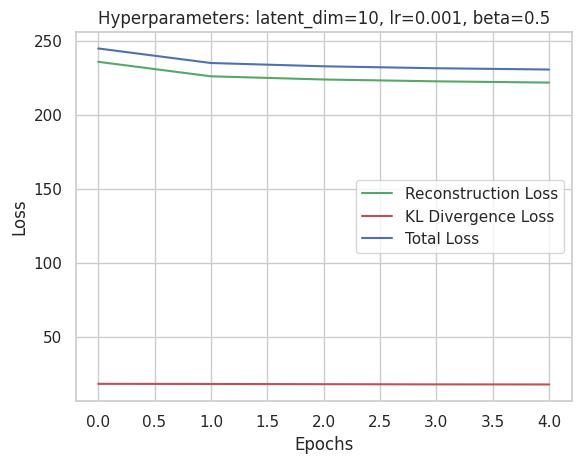


Testing combination 2/18:
latent_dim=10, condition_dim=10, learning_rate=0.001, beta=1, epochs=5
Epoch [1/5], Recon Loss: 240.4225, KL Loss: 12.7647, Total Loss: 253.1872
Epoch [2/5], Recon Loss: 230.3000, KL Loss: 12.5523, Total Loss: 242.8524
Epoch [3/5], Recon Loss: 228.0229, KL Loss: 12.4807, Total Loss: 240.5036
Epoch [4/5], Recon Loss: 226.6428, KL Loss: 12.4329, Total Loss: 239.0757
Epoch [5/5], Recon Loss: 225.7469, KL Loss: 12.4518, Total Loss: 238.1988


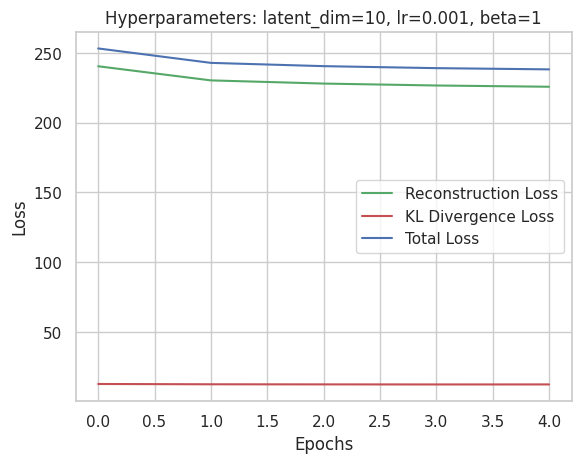


Testing combination 3/18:
latent_dim=10, condition_dim=10, learning_rate=0.001, beta=2, epochs=5
Epoch [1/5], Recon Loss: 247.2837, KL Loss: 8.0729, Total Loss: 263.4295
Epoch [2/5], Recon Loss: 237.5435, KL Loss: 7.9284, Total Loss: 253.4002
Epoch [3/5], Recon Loss: 235.0262, KL Loss: 7.9536, Total Loss: 250.9333
Epoch [4/5], Recon Loss: 233.6031, KL Loss: 8.0291, Total Loss: 249.6613
Epoch [5/5], Recon Loss: 232.6217, KL Loss: 8.0554, Total Loss: 248.7325


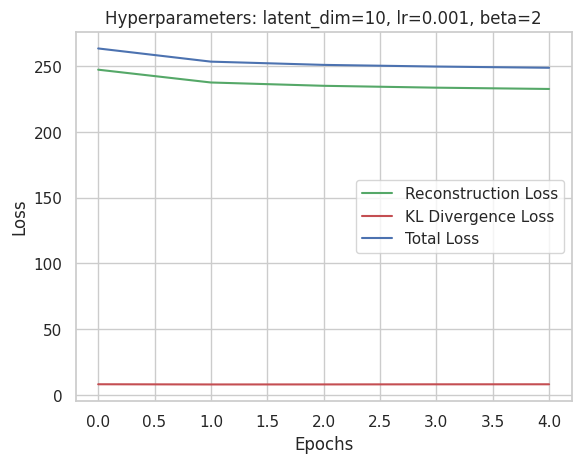


Testing combination 4/18:
latent_dim=10, condition_dim=10, learning_rate=0.0001, beta=0.5, epochs=5
Epoch [1/5], Recon Loss: 247.4125, KL Loss: 18.5556, Total Loss: 256.6904
Epoch [2/5], Recon Loss: 228.6667, KL Loss: 19.0492, Total Loss: 238.1913
Epoch [3/5], Recon Loss: 226.0280, KL Loss: 18.9826, Total Loss: 235.5193
Epoch [4/5], Recon Loss: 224.5599, KL Loss: 18.9628, Total Loss: 234.0413
Epoch [5/5], Recon Loss: 223.6241, KL Loss: 18.9338, Total Loss: 233.0910


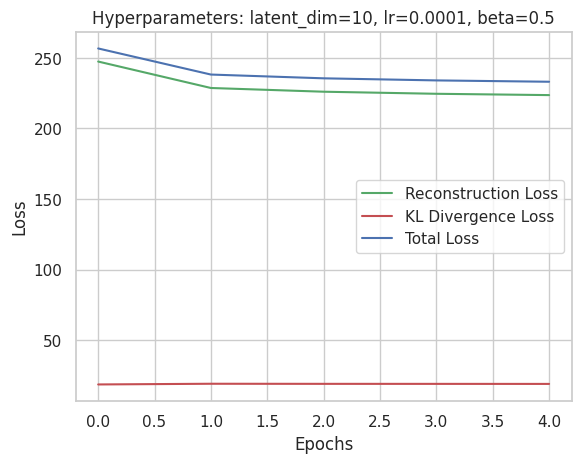


Testing combination 5/18:
latent_dim=10, condition_dim=10, learning_rate=0.0001, beta=1, epochs=5
Epoch [1/5], Recon Loss: 265.7733, KL Loss: 13.0464, Total Loss: 278.8197
Epoch [2/5], Recon Loss: 233.2444, KL Loss: 13.5659, Total Loss: 246.8103
Epoch [3/5], Recon Loss: 230.2136, KL Loss: 13.6153, Total Loss: 243.8289
Epoch [4/5], Recon Loss: 228.6918, KL Loss: 13.6324, Total Loss: 242.3243
Epoch [5/5], Recon Loss: 227.6613, KL Loss: 13.5613, Total Loss: 241.2226


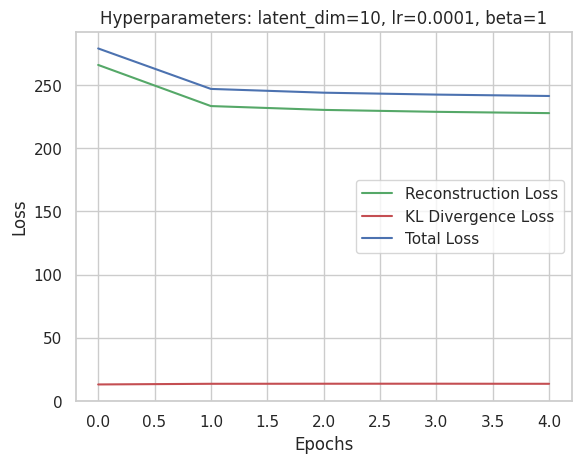


Testing combination 6/18:
latent_dim=10, condition_dim=10, learning_rate=0.0001, beta=2, epochs=5
Epoch [1/5], Recon Loss: 270.2801, KL Loss: 8.2377, Total Loss: 286.7555
Epoch [2/5], Recon Loss: 240.6688, KL Loss: 8.5523, Total Loss: 257.7733
Epoch [3/5], Recon Loss: 237.5825, KL Loss: 8.6056, Total Loss: 254.7936
Epoch [4/5], Recon Loss: 236.0320, KL Loss: 8.6130, Total Loss: 253.2579
Epoch [5/5], Recon Loss: 234.9427, KL Loss: 8.5310, Total Loss: 252.0047


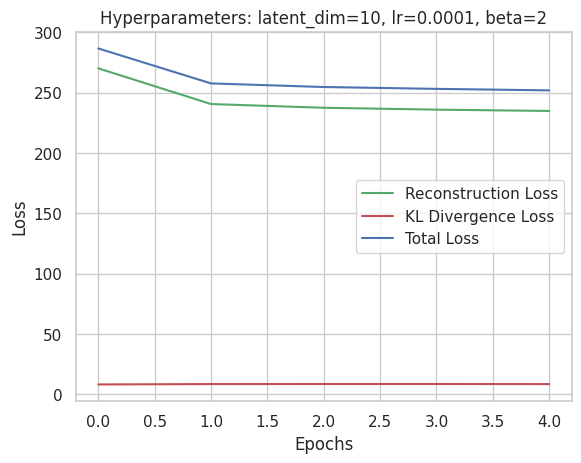


Testing combination 7/18:
latent_dim=20, condition_dim=10, learning_rate=0.001, beta=0.5, epochs=5
Epoch [1/5], Recon Loss: 233.1195, KL Loss: 23.3496, Total Loss: 244.7943
Epoch [2/5], Recon Loss: 222.5323, KL Loss: 23.0292, Total Loss: 234.0469
Epoch [3/5], Recon Loss: 220.3864, KL Loss: 22.6660, Total Loss: 231.7194
Epoch [4/5], Recon Loss: 219.1426, KL Loss: 22.4920, Total Loss: 230.3886
Epoch [5/5], Recon Loss: 218.3197, KL Loss: 22.3784, Total Loss: 229.5089


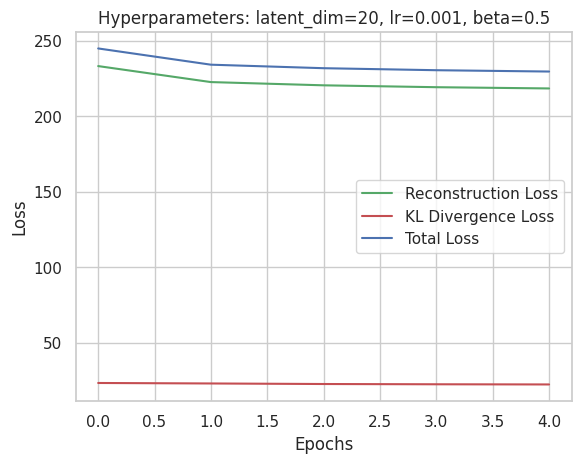


Testing combination 8/18:
latent_dim=20, condition_dim=10, learning_rate=0.001, beta=1, epochs=5
Epoch [1/5], Recon Loss: 239.6093, KL Loss: 14.5704, Total Loss: 254.1797
Epoch [2/5], Recon Loss: 229.1023, KL Loss: 14.2018, Total Loss: 243.3041
Epoch [3/5], Recon Loss: 226.7804, KL Loss: 14.0075, Total Loss: 240.7879
Epoch [4/5], Recon Loss: 225.5356, KL Loss: 13.9013, Total Loss: 239.4369
Epoch [5/5], Recon Loss: 224.6239, KL Loss: 13.9002, Total Loss: 238.5241


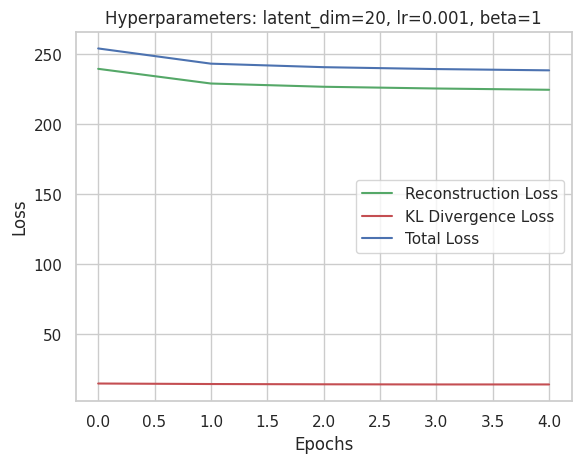


Testing combination 9/18:
latent_dim=20, condition_dim=10, learning_rate=0.001, beta=2, epochs=5
Epoch [1/5], Recon Loss: 248.6727, KL Loss: 8.1801, Total Loss: 265.0329
Epoch [2/5], Recon Loss: 238.3423, KL Loss: 7.9142, Total Loss: 254.1706
Epoch [3/5], Recon Loss: 235.6580, KL Loss: 7.9388, Total Loss: 251.5355
Epoch [4/5], Recon Loss: 234.0899, KL Loss: 7.9887, Total Loss: 250.0672
Epoch [5/5], Recon Loss: 233.1105, KL Loss: 8.0314, Total Loss: 249.1733


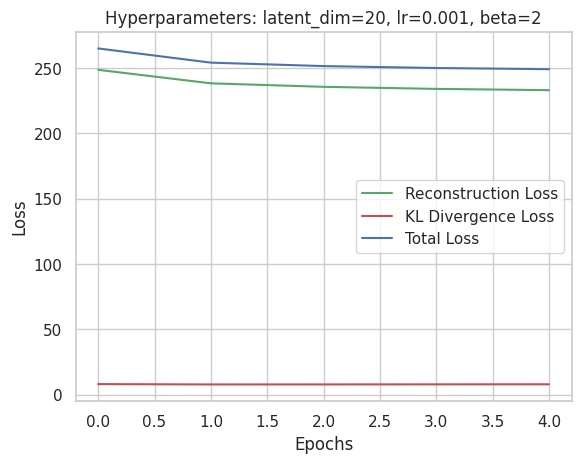


Testing combination 10/18:
latent_dim=20, condition_dim=10, learning_rate=0.0001, beta=0.5, epochs=5
Epoch [1/5], Recon Loss: 249.0678, KL Loss: 25.2968, Total Loss: 261.7162
Epoch [2/5], Recon Loss: 226.0911, KL Loss: 25.2709, Total Loss: 238.7265
Epoch [3/5], Recon Loss: 223.0809, KL Loss: 25.0816, Total Loss: 235.6217
Epoch [4/5], Recon Loss: 221.4949, KL Loss: 24.8420, Total Loss: 233.9159
Epoch [5/5], Recon Loss: 220.5314, KL Loss: 24.6584, Total Loss: 232.8605


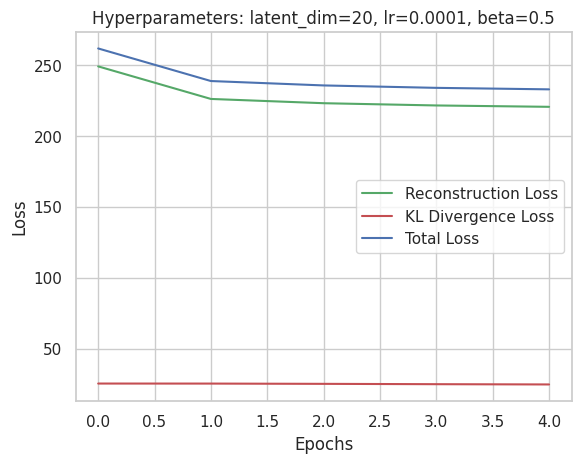


Testing combination 11/18:
latent_dim=20, condition_dim=10, learning_rate=0.0001, beta=1, epochs=5
Epoch [1/5], Recon Loss: 250.9119, KL Loss: 16.4663, Total Loss: 267.3782
Epoch [2/5], Recon Loss: 232.3355, KL Loss: 16.0156, Total Loss: 248.3511
Epoch [3/5], Recon Loss: 229.3201, KL Loss: 15.8481, Total Loss: 245.1681
Epoch [4/5], Recon Loss: 227.8318, KL Loss: 15.6379, Total Loss: 243.4697
Epoch [5/5], Recon Loss: 226.7571, KL Loss: 15.4990, Total Loss: 242.2562


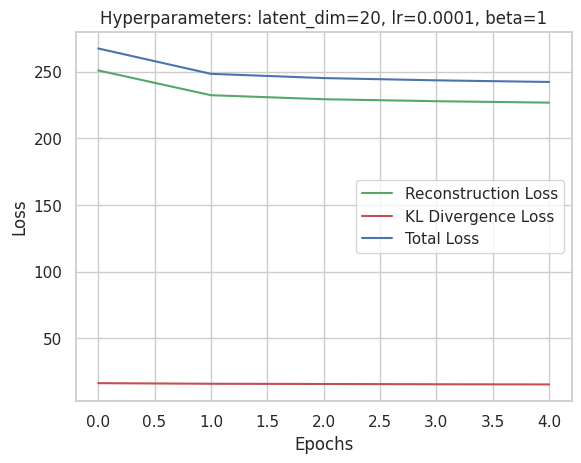


Testing combination 12/18:
latent_dim=20, condition_dim=10, learning_rate=0.0001, beta=2, epochs=5
Epoch [1/5], Recon Loss: 263.4338, KL Loss: 9.6952, Total Loss: 282.8242
Epoch [2/5], Recon Loss: 241.8563, KL Loss: 9.2816, Total Loss: 260.4196
Epoch [3/5], Recon Loss: 238.6888, KL Loss: 9.1511, Total Loss: 256.9911
Epoch [4/5], Recon Loss: 237.0186, KL Loss: 9.0285, Total Loss: 255.0756
Epoch [5/5], Recon Loss: 235.8819, KL Loss: 8.9338, Total Loss: 253.7495


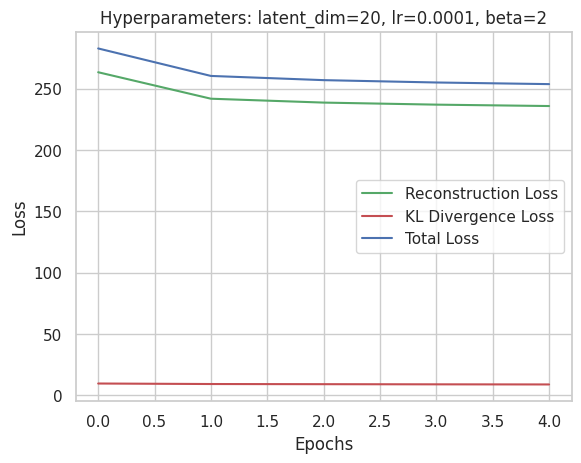


Testing combination 13/18:
latent_dim=30, condition_dim=10, learning_rate=0.001, beta=0.5, epochs=5
Epoch [1/5], Recon Loss: 233.0548, KL Loss: 24.5515, Total Loss: 245.3306
Epoch [2/5], Recon Loss: 222.4301, KL Loss: 23.9599, Total Loss: 234.4100
Epoch [3/5], Recon Loss: 220.2563, KL Loss: 23.6949, Total Loss: 232.1037
Epoch [4/5], Recon Loss: 219.0195, KL Loss: 23.4179, Total Loss: 230.7284
Epoch [5/5], Recon Loss: 218.2524, KL Loss: 23.2260, Total Loss: 229.8653


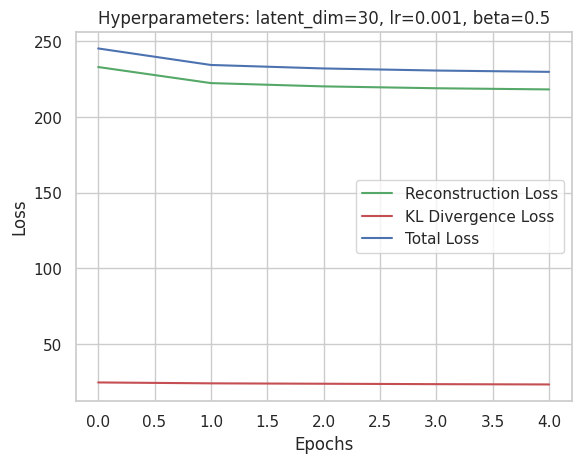


Testing combination 14/18:
latent_dim=30, condition_dim=10, learning_rate=0.001, beta=1, epochs=5
Epoch [1/5], Recon Loss: 240.3815, KL Loss: 14.6250, Total Loss: 255.0065
Epoch [2/5], Recon Loss: 229.6103, KL Loss: 14.1748, Total Loss: 243.7851
Epoch [3/5], Recon Loss: 227.2376, KL Loss: 14.0131, Total Loss: 241.2507
Epoch [4/5], Recon Loss: 225.7849, KL Loss: 13.9046, Total Loss: 239.6895
Epoch [5/5], Recon Loss: 224.8706, KL Loss: 13.8782, Total Loss: 238.7489


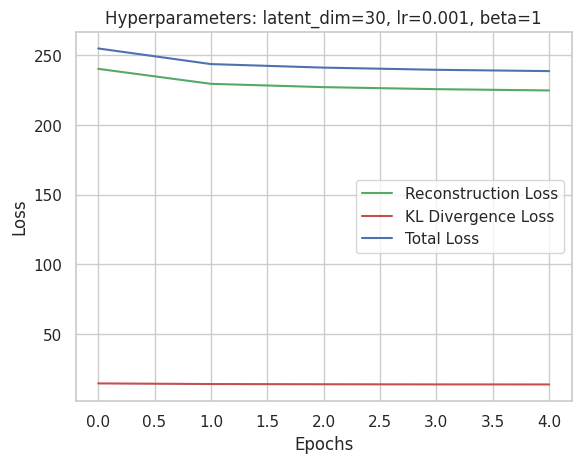


Testing combination 15/18:
latent_dim=30, condition_dim=10, learning_rate=0.001, beta=2, epochs=5
Epoch [1/5], Recon Loss: 250.5538, KL Loss: 8.2762, Total Loss: 267.1062
Epoch [2/5], Recon Loss: 238.8805, KL Loss: 7.9193, Total Loss: 254.7191
Epoch [3/5], Recon Loss: 236.0448, KL Loss: 7.9292, Total Loss: 251.9032
Epoch [4/5], Recon Loss: 234.4192, KL Loss: 7.9368, Total Loss: 250.2928
Epoch [5/5], Recon Loss: 233.2215, KL Loss: 7.9928, Total Loss: 249.2070


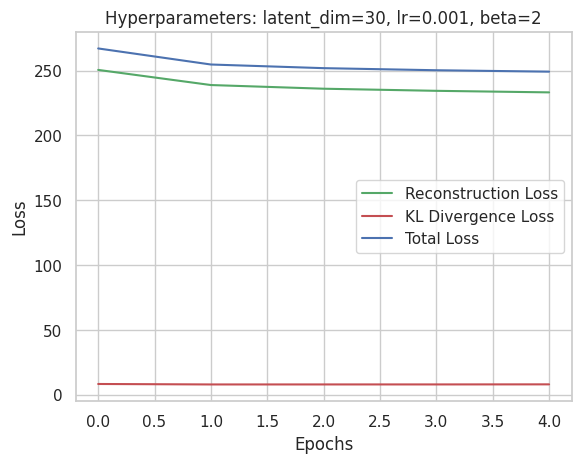


Testing combination 16/18:
latent_dim=30, condition_dim=10, learning_rate=0.0001, beta=0.5, epochs=5
Epoch [1/5], Recon Loss: 250.5492, KL Loss: 28.1839, Total Loss: 264.6412
Epoch [2/5], Recon Loss: 226.2051, KL Loss: 27.3669, Total Loss: 239.8886
Epoch [3/5], Recon Loss: 222.9211, KL Loss: 26.7357, Total Loss: 236.2890
Epoch [4/5], Recon Loss: 221.3407, KL Loss: 26.4119, Total Loss: 234.5467
Epoch [5/5], Recon Loss: 220.2754, KL Loss: 26.1110, Total Loss: 233.3309


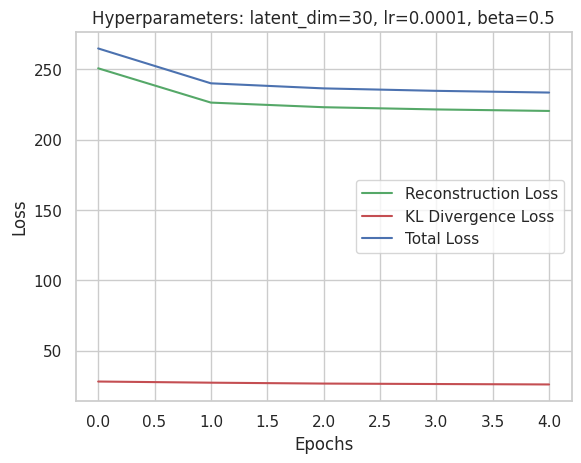


Testing combination 17/18:
latent_dim=30, condition_dim=10, learning_rate=0.0001, beta=1, epochs=5
Epoch [1/5], Recon Loss: 258.5410, KL Loss: 16.4782, Total Loss: 275.0192
Epoch [2/5], Recon Loss: 233.5699, KL Loss: 15.8435, Total Loss: 249.4134
Epoch [3/5], Recon Loss: 230.1543, KL Loss: 15.7497, Total Loss: 245.9040
Epoch [4/5], Recon Loss: 228.4458, KL Loss: 15.5508, Total Loss: 243.9966
Epoch [5/5], Recon Loss: 227.3381, KL Loss: 15.4125, Total Loss: 242.7506


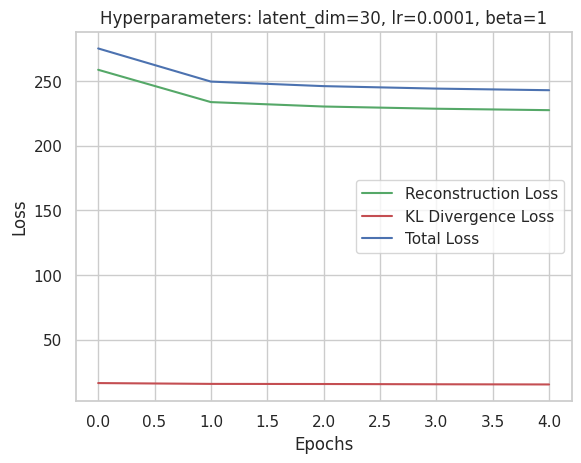


Testing combination 18/18:
latent_dim=30, condition_dim=10, learning_rate=0.0001, beta=2, epochs=5
Epoch [1/5], Recon Loss: 264.8073, KL Loss: 9.7015, Total Loss: 284.2103
Epoch [2/5], Recon Loss: 243.2766, KL Loss: 9.2860, Total Loss: 261.8486
Epoch [3/5], Recon Loss: 239.8093, KL Loss: 9.1034, Total Loss: 258.0162
Epoch [4/5], Recon Loss: 237.9674, KL Loss: 8.9616, Total Loss: 255.8906
Epoch [5/5], Recon Loss: 236.6149, KL Loss: 8.8399, Total Loss: 254.2947


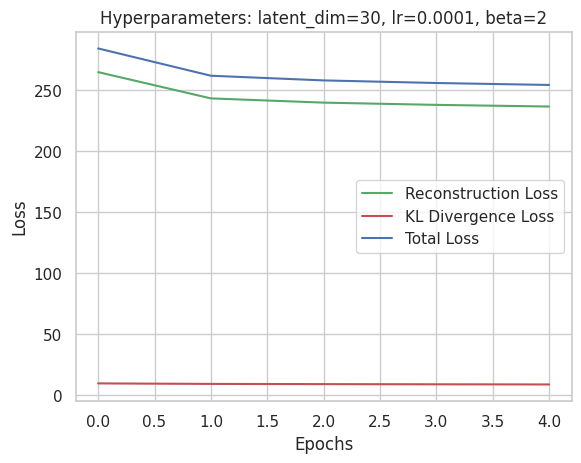


Grid Search Complete!
Best Hyperparameters: {'latent_dim': 20, 'condition_dim': 10, 'learning_rate': 0.001, 'beta': 0.5, 'epochs': 5}
Lowest Test Loss: 230.3804


In [ ]:
import itertools

# Hyperparameters
param_grid = {
    'latent_dim': [10, 20, 30],
    'learning_rate': [1e-3, 1e-4],
    'beta': [0.5, 1, 2],  # weight for KL divergence
}

batch_size = 128
epochs = 5  # Reduced epochs for faster testing
condition_dim = 10  # Number of classes (10 for Fashion-MNIST)

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(*param_grid.values()))
best_params = None
lowest_test_loss = float('inf')

print(f"Total hyperparameter combinations: {len(param_combinations)}")

for idx, params in enumerate(param_combinations):
    latent_dim, learning_rate, beta = params
    print(f"\nTesting combination {idx + 1}/{len(param_combinations)}:")
    print(f"latent_dim={latent_dim}, condition_dim={condition_dim}, learning_rate={learning_rate}, beta={beta}, epochs={epochs}")

    # Initialize the CVAE model and optimizer
    cvae = CVAE(latent_dim=latent_dim, condition_dim=condition_dim).to(device)
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

    reconstruction_losses = []
    kl_losses = []
    total_losses = []

    for epoch in range(1, epochs + 1):
        cvae.train()
        epoch_recon_loss = 0.0
        epoch_kl_loss = 0.0
        epoch_total_loss = 0.0

        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)
            c = F.one_hot(labels, num_classes=condition_dim).float()

            optimizer.zero_grad()
            recon_batch, mu, logvar = cvae(data, c)
            #recon_loss, kl_loss, total_loss = loss_function_cvae(recon_batch, data, mu, logvar, beta)
            total_loss, recon_loss, kl_loss = loss_function_cvae(recon_batch, data, mu, logvar, beta)
            total_loss.backward()
            optimizer.step()

            # losses
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()
            epoch_total_loss += total_loss.item()

        reconstruction_losses.append(epoch_recon_loss / len(train_loader.dataset))
        kl_losses.append(epoch_kl_loss / len(train_loader.dataset))
        total_losses.append(epoch_total_loss / len(train_loader.dataset))

        print(f"Epoch [{epoch}/{epochs}], Recon Loss: {epoch_recon_loss / len(train_loader.dataset):.4f}, KL Loss: {epoch_kl_loss / len(train_loader.dataset):.4f}, Total Loss: {epoch_total_loss / len(train_loader.dataset):.4f}")

    # Validation Phase
    cvae.eval()
    test_loss = 0.0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            c = F.one_hot(labels, num_classes=condition_dim).float()

            recon_batch, mu, logvar = cvae(data, c)
            loss, _, _ = loss_function_cvae(recon_batch, data, mu, logvar, beta)
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)

    if test_loss < lowest_test_loss:
        lowest_test_loss = test_loss
        best_params = {
            'latent_dim': latent_dim,
            'condition_dim': condition_dim,
            'learning_rate': learning_rate,
            'beta': beta,
            'epochs': epochs,
        }

    plt.plot(reconstruction_losses, label="Reconstruction Loss", color='g')
    plt.plot(kl_losses, label="KL Divergence Loss", color='r')
    plt.plot(total_losses, label="Total Loss", color='b')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Hyperparameters: latent_dim={latent_dim}, lr={learning_rate}, beta={beta}")
    plt.legend()
    plt.show()

print("\nGrid Search Complete!")
print(f"Best Hyperparameters: {best_params}")
print(f"Lowest Test Loss: {lowest_test_loss:.4f}")


We observe the same curve shape for all of our loss plots throughout the grid search, with the reconstruction loss dominating the total loss value. While the KL loss remains relatively stable, the reconstruction loss shows a steady decrease, which reduces the overall loss. This consistent pattern across the different hyperparameter combinations tels us that the reconstruction term is the main contributor to the training of the model. (We will explore this further when we plot the latent visualizations later).

### Other final outputs:

**Outputs only using one epoch:**

Best Hyperparameters: {'latent_dim': 20, 'condition_dim': 10, 'learning_rate': 0.001, 'beta': 0.5, 'epochs': 1}

Lowest Test Loss: 239.4686



**Outputs using five epoch:**

Best Hyperparameters: {'latent_dim': 20, 'condition_dim': 10, 'learning_rate': 0.001, 'beta': 0.5, 'epochs': 5}

Lowest Test Loss: 231.8222


## Training the model with optimized hyperparameters

Since increasing the number of epochs impoves the loss of the model we will use 30 epochs when training the final model, as well as using the hyperparameters found in the grid search.

Training, tracking and plotting the loss terms

Epoch 1, Loss: 244.4283, Recon: 232.8809, KL: 23.0949
Epoch 2, Loss: 233.9370, Recon: 222.5405, KL: 22.7931
Epoch 3, Loss: 231.6209, Recon: 220.3644, KL: 22.5130
Epoch 4, Loss: 230.4296, Recon: 219.2398, KL: 22.3798
Epoch 5, Loss: 229.5221, Recon: 218.3982, KL: 22.2477
Epoch 6, Loss: 228.8816, Recon: 217.7910, KL: 22.1811
Epoch 7, Loss: 228.4262, Recon: 217.3567, KL: 22.1391
Epoch 8, Loss: 228.0089, Recon: 216.9454, KL: 22.1269
Epoch 9, Loss: 227.6791, Recon: 216.6305, KL: 22.0971
Epoch 10, Loss: 227.4427, Recon: 216.4196, KL: 22.0461
Epoch 11, Loss: 227.1571, Recon: 216.1426, KL: 22.0291
Epoch 12, Loss: 226.9818, Recon: 215.9678, KL: 22.0281
Epoch 13, Loss: 226.7681, Recon: 215.7573, KL: 22.0217
Epoch 14, Loss: 226.6277, Recon: 215.6239, KL: 22.0076
Epoch 15, Loss: 226.4451, Recon: 215.4404, KL: 22.0095
Epoch 16, Loss: 226.3394, Recon: 215.3457, KL: 21.9875
Epoch 17, Loss: 226.2058, Recon: 215.2099, KL: 21.9918
Epoch 18, Loss: 226.1235, Recon: 215.1096, KL: 22.0279
Epoch 19, Loss: 225

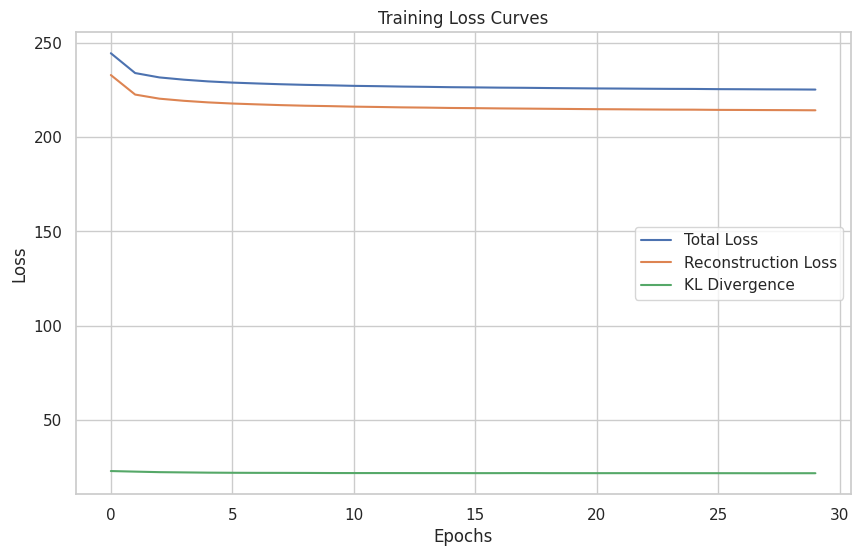

In [ ]:
# Hyperparameters
latent_dim = 20
condition_dim = 10
learning_rate = 1e-3
epochs = 30 #30
beta = 0.5 #1

batch_size = 128

reconstruction_losses = []
kl_divergence_losses = []
total_losses = []

cvae = CVAE(latent_dim=latent_dim, condition_dim=condition_dim).to(device) # The model
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

for epoch in range(1, epochs + 1):
    cvae.train()
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    running_total_loss = 0.0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        c = F.one_hot(labels, num_classes=condition_dim).float()  # One-hot encoding for condition vector
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, c)

        loss, recon_loss, kl_loss = loss_function_cvae(recon_batch, data, mu, logvar, beta)

        loss.backward()
        optimizer.step()
        running_recon_loss += recon_loss.item()
        running_kl_loss += kl_loss.item()
        running_total_loss += loss.item()

    epoch_recon_loss = running_recon_loss / len(train_loader.dataset)
    epoch_kl_loss = running_kl_loss / len(train_loader.dataset)
    epoch_total_loss = running_total_loss / len(train_loader.dataset)

    reconstruction_losses.append(epoch_recon_loss)
    kl_divergence_losses.append(epoch_kl_loss)
    total_losses.append(epoch_total_loss)

    print(f"Epoch {epoch}, Loss: {epoch_total_loss:.4f}, Recon: {epoch_recon_loss:.4f}, KL: {epoch_kl_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(total_losses, label="Total Loss")
plt.plot(reconstruction_losses, label="Reconstruction Loss")
plt.plot(kl_divergence_losses, label="KL Divergence")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.show()


# Visulaisation

Using the function provided from the course we can now plot the results.

In [ ]:
import matplotlib.pyplot as plt

def image_comparison(original_images, reconstructions, n_images=6):
    """Plots the original images and its reconstructions for comparison

    Args:
        original_image (torch.Tensor): The original images
        reconstructions (torch.Tensor): Reconstruction of the original images
    """
    fig, ax = plt.subplots(2, n_images, figsize=(10, 5))

    for i in range(n_images):
        # Plot original images
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, 0].set_title('Original')

        # Reconstructed images
        ax[1, i].imshow(reconstructions[i], cmap='gray')
        ax[1, i].axis('off')
        ax[1, 0].set_title('Recomstruction')

    plt.tight_layout()
    plt.show()

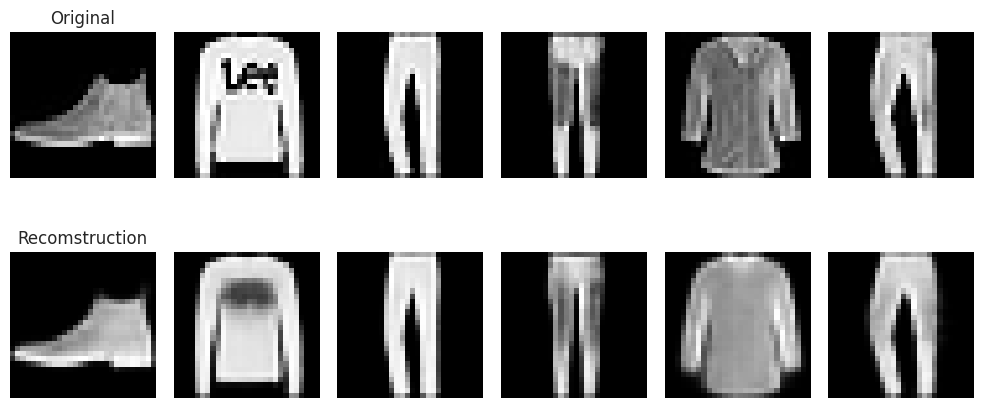

In [ ]:
random_images, labels = next(iter(test_loader))

c = F.one_hot(labels, num_classes=condition_dim).float().to(device)  # Convert labels to one-hot encoding

recons, _, _ = cvae(random_images.to(device), c)  # Get the reconstructions of the selected images

random_images = random_images.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

# Plot the original images and their reconstructions
image_comparison(random_images, recons)

# Generating 5 new samples

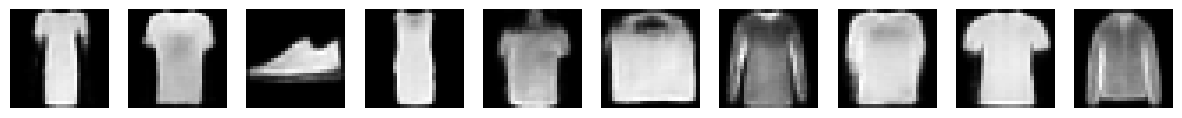

In [ ]:
def generate_sample(num_samples=10):
    cvae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)  # Sample random latent vectors

        random_labels = torch.randint(0, condition_dim, (num_samples,)).to(device)  # Random class labels
        c = F.one_hot(random_labels, num_classes=condition_dim).float().to(device)  # One-hot encode labels

        samples = cvae.decode(z,c) # Decode the latent vectors
        samples = samples.cpu().view(num_samples, 1, 28, 28) # Reshape the samples

        fig, ax = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
        plt.show()

generate_sample()

Unlike a normal VAE, the CVAE allows us to generate samples from specific classes. In this case, we will plot five generated samples from each class by sampling from the latent space and decoding the images.

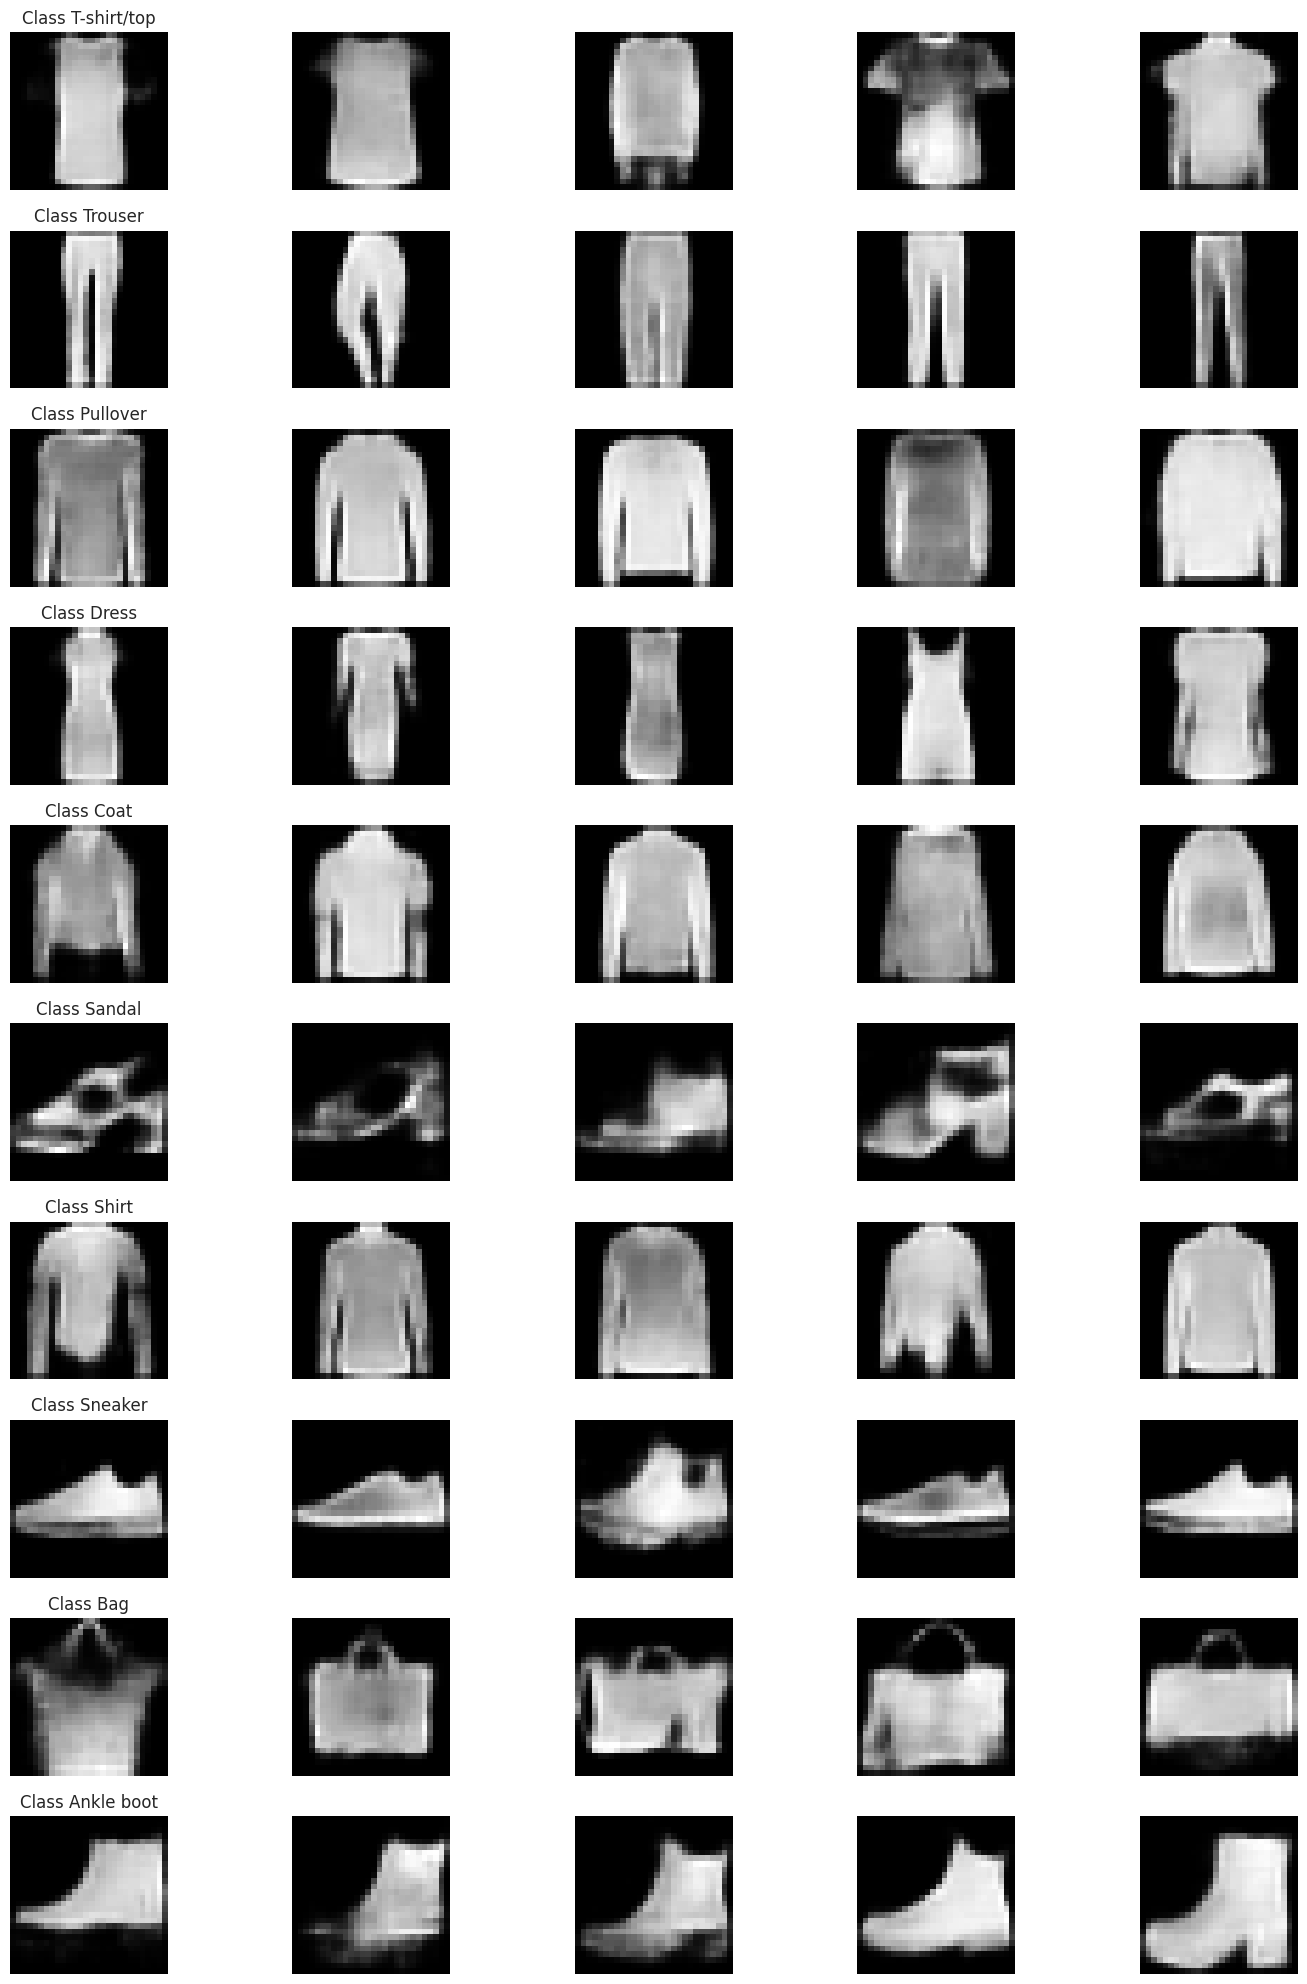

In [ ]:
def generate_sample_per_class(num_samples_per_class=5):
    cvae.eval()
    with torch.no_grad():
        fig, ax = plt.subplots(condition_dim, num_samples_per_class, figsize=(15, 2 * condition_dim))

        for class_idx in range(condition_dim):
            z = torch.randn(num_samples_per_class, latent_dim).to(device)  # Sample random latent vectors
            c = F.one_hot(torch.full((num_samples_per_class,), class_idx), num_classes=condition_dim).float().to(device)  # One-hot encode class label

            samples = cvae.decode(z, c)  # Decode the latent vectors
            samples = samples.cpu().view(num_samples_per_class, 1, 28, 28)  # Reshape the samples

            for i in range(num_samples_per_class):
                ax[class_idx, i].imshow(samples[i].squeeze(0), cmap='gray')
                ax[class_idx, i].axis('off')
                ax[class_idx, i].set_title(f'Class {class_names[class_idx]}' if i == 0 else "")

        plt.tight_layout()
        plt.show()

# Call the function to generate samples
generate_sample_per_class(num_samples_per_class=5)


We can see that the model is able to generate new samples from each class. Just like the original images, these images are blurry, but we can distinguish the groups.

On the other hand, we can see that some of the clothing classes might be close in the latent space. For example, we can see that some of the t-shirt examples could also look like dresses due to a long "torso."

Let's now visualize the latent space to better understand the model and the impact of the beta term (KL weight).

## Visualizing the latent space


Training VAE with KL Weight = 1
Epoch 1: Average Loss: 253.5971, BCE: 239.2655, KLD: 14.3316
Epoch 2: Average Loss: 243.1360, BCE: 229.0766, KLD: 14.0594
Epoch 3: Average Loss: 240.6787, BCE: 226.7053, KLD: 13.9734
Epoch 4: Average Loss: 239.3161, BCE: 225.3586, KLD: 13.9575
Epoch 5: Average Loss: 238.4183, BCE: 224.5152, KLD: 13.9031
Epoch 6: Average Loss: 237.7509, BCE: 223.8343, KLD: 13.9166
Epoch 7: Average Loss: 237.2492, BCE: 223.3659, KLD: 13.8834
Epoch 8: Average Loss: 236.8258, BCE: 222.9237, KLD: 13.9021
Epoch 9: Average Loss: 236.4608, BCE: 222.5654, KLD: 13.8954
Epoch 10: Average Loss: 236.2020, BCE: 222.3236, KLD: 13.8784
Epoch 11: Average Loss: 235.9639, BCE: 222.0831, KLD: 13.8808
Epoch 12: Average Loss: 235.7227, BCE: 221.8762, KLD: 13.8465
Epoch 13: Average Loss: 235.5276, BCE: 221.6418, KLD: 13.8858
Epoch 14: Average Loss: 235.3109, BCE: 221.4493, KLD: 13.8616
Epoch 15: Average Loss: 235.1453, BCE: 221.3096, KLD: 13.8357
Epoch 16: Average Loss: 235.0112, BCE: 221.170

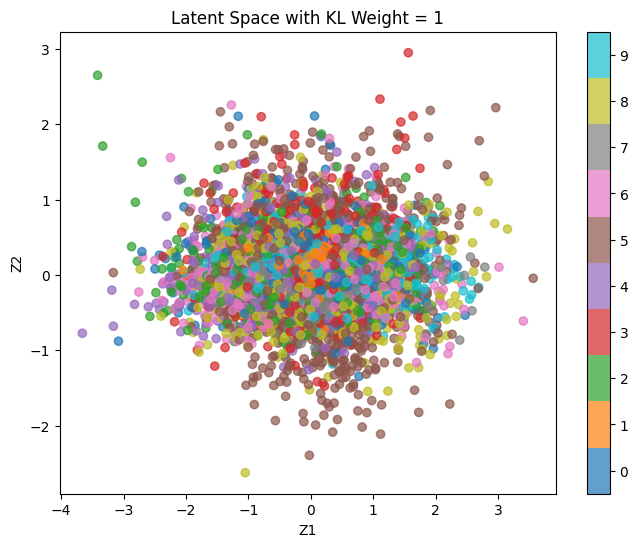


Training VAE with KL Weight = 10
Epoch 1: Average Loss: 294.5880, BCE: 278.1143, KLD: 1.6474
Epoch 2: Average Loss: 283.6737, BCE: 265.6870, KLD: 1.7987
Epoch 3: Average Loss: 281.4017, BCE: 262.8149, KLD: 1.8587
Epoch 4: Average Loss: 280.2212, BCE: 261.2376, KLD: 1.8984
Epoch 5: Average Loss: 279.6312, BCE: 260.3625, KLD: 1.9269
Epoch 6: Average Loss: 279.1413, BCE: 259.5891, KLD: 1.9552
Epoch 7: Average Loss: 278.6558, BCE: 259.0603, KLD: 1.9595
Epoch 8: Average Loss: 278.3700, BCE: 258.5498, KLD: 1.9820
Epoch 9: Average Loss: 278.1073, BCE: 258.1984, KLD: 1.9909
Epoch 10: Average Loss: 277.9622, BCE: 257.8739, KLD: 2.0088
Epoch 11: Average Loss: 277.8751, BCE: 257.7174, KLD: 2.0158
Epoch 12: Average Loss: 277.5410, BCE: 257.3568, KLD: 2.0184
Epoch 13: Average Loss: 277.4029, BCE: 257.1779, KLD: 2.0225
Epoch 14: Average Loss: 277.3583, BCE: 257.0965, KLD: 2.0262
Epoch 15: Average Loss: 277.3054, BCE: 256.8594, KLD: 2.0446
Epoch 16: Average Loss: 277.0754, BCE: 256.6783, KLD: 2.0397

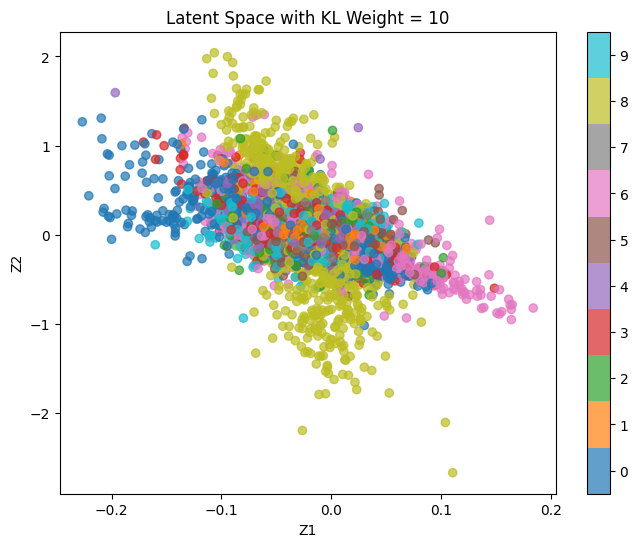


Training VAE with KL Weight = 100
Epoch 1: Average Loss: 316.2317, BCE: 313.1516, KLD: 0.0308
Epoch 2: Average Loss: 308.7759, BCE: 308.5239, KLD: 0.0025
Epoch 3: Average Loss: 308.1955, BCE: 308.1034, KLD: 0.0009
Epoch 4: Average Loss: 307.9291, BCE: 307.8599, KLD: 0.0007
Epoch 5: Average Loss: 307.7649, BCE: 307.7105, KLD: 0.0005
Epoch 6: Average Loss: 307.6889, BCE: 307.6497, KLD: 0.0004
Epoch 7: Average Loss: 307.6320, BCE: 307.5936, KLD: 0.0004
Epoch 8: Average Loss: 307.5500, BCE: 307.5164, KLD: 0.0003
Epoch 9: Average Loss: 307.5072, BCE: 307.4764, KLD: 0.0003
Epoch 10: Average Loss: 307.5048, BCE: 307.4763, KLD: 0.0003
Epoch 11: Average Loss: 307.4622, BCE: 307.4398, KLD: 0.0002
Epoch 12: Average Loss: 307.4333, BCE: 307.4111, KLD: 0.0002
Epoch 13: Average Loss: 307.4294, BCE: 307.4098, KLD: 0.0002
Epoch 14: Average Loss: 307.3866, BCE: 307.3638, KLD: 0.0002
Epoch 15: Average Loss: 307.3824, BCE: 307.3627, KLD: 0.0002
Epoch 16: Average Loss: 307.3872, BCE: 307.3718, KLD: 0.000

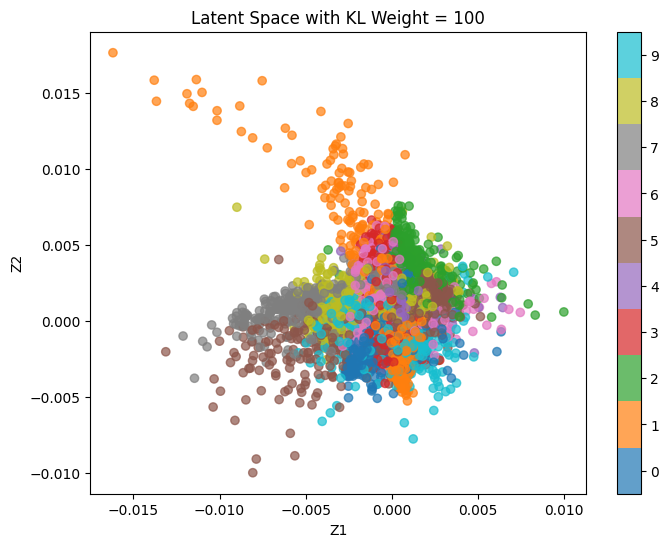

In [ ]:
# Hyperparameters
latent_dims = 20
condition_dim = 10 ###
batch_size = 128
num_epochs = 30
learning_rate = 1e-3
kl_weights = [1, 10, 100]  # Different weights for the KL divergence term

# Training and plotting function
def train_and_plot(kl_weight):
    model = CVAE(latent_dims, condition_dim).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):  # Assuming labels is the class label

            data = data.to(device)
            labels = labels.to(device)

            # Convert labels to one-hot encoding for the condition vector `c`
            c = F.one_hot(labels, num_classes=condition_dim).float()  # One-hot encoded condition vector

            optimizer.zero_grad()

            # print(np.shape(data))

            recon_batch, mu, logvar = model(data, c)

            loss,bce,kld = loss_function_cvae(recon_batch, data, mu, logvar, kl_weight) # using the CVAE loss function

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()

        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')

    plot_latent_space(model, kl_weight)

#plot latent space
def plot_latent_space(model, kl_weight):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        labels = labels.to(device)
        c = F.one_hot(labels, num_classes=condition_dim).float()  # One-hot encoded condition vector
        mu, logvar = model.encode(data,c)
        z = mu  # For visualization, we use the mean
        z = z.cpu().numpy()
        labels = labels.cpu().numpy()

        plt.figure(figsize=(8,6))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()

for kl_weight in kl_weights:
    print(f'\nTraining CVAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight)

## Comments on the latent space representation
When we look at the latent representations for KL weight = 1, we can see that the classes aren't well separated. This indicates that the model is focusing more on getting the reconstruction right, but not necessarily on organizing the latent space in a way that clearly distinguishes between different classes. The model might be overfitting to the reconstruction task, without enough emphasis on learning a structured latent space.


However, when we increase KL weight to 10 and 100, we see much better class separation. This happens because the model is putting more weight on the KL divergence term, which helps it learn a more structured latent space. As a result, the model is encouraged to group similar classes together in the latent space, making the representation more organized and interpretable.


That said, when KL weight becomes too large, like 100, we might start to see some downsides. The latent space might become too regularized, meaning the model simplifies things too much, which could hurt the reconstruction quality and make the model less flexible in capturing finer details. So, while increasing KL weight improves class separation, it's important to find the right balance.

# Sources:

Kihyuk Sohn, Xinchen Yan and Honglak Lee(2015). Learning Structured Output Representation using Deep Conditional Generative Models. Retrieved from https://proceedings.neurips.cc/paper_files/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf

Pyro.ai. (n.d.). Conditional Variational Autoencoder (CVAE). Retrieved from https://pyro.ai/examples/cvae.html

Beckham, R. (2023, April 27). Conditional Variational Autoencoders (CVAE). Retrieved from https://beckham.nz/2023/04/27/conditional-vaes.html

Shiksha.com. (n.d.). ReLU and Sigmoid Activation Functions. Retrieved from https://www.shiksha.com/online-courses/articles/relu-and-sigmoid-activation-function/#ReLU

Zalando Research. (n.d.). Fashion MNIST: A Dataset for Fashion Recognition. Retrieved from https://github.com/zalandoresearch/fashion-mnist
